In [1]:
import argparse
from dataset import *
from models import * 
from generation import *
import numpy as np

from torch.utils.data import DataLoader
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
DIR_PATH = "dataset/poems.csv"
SOV_TOKEN = "<SOV>" # start of verse
EOV_TOKEN = "<EOV>" # end of verse

parser = argparse.ArgumentParser()
parser.add_argument('--max_epochs', type=int, default=10)
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--sequence_length', type=int, default=10)
args, unknown = parser.parse_known_args()

# Define the dataset and dataloader
dataset = SpanishPoemsDataset(DIR_PATH, SOV_TOKEN, EOV_TOKEN, args)
dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False)

print(dataset.__getitem__(3))
print('Vocab:', len(dataset.unique_words))

(tensor([2449, 1375,    1,    0,    6,   15, 2450, 2451,    5,   66]), tensor([1375,    1,    0,    6,   15, 2450, 2451,    5,   66, 2452]))
Vocab: 7506


In [3]:
# Set hyperparameters

input_size = len(dataset.unique_words) # size of the vocabulary for the input sequence
output_size = len(dataset.unique_words) # size of the vocabulary for the target sequence
hidden_size = 128
num_layers = 1
batch_size = args.batch_size
sequence_length = args.sequence_length
num_epochs = args.max_epochs
learning_rate = 0.001
save_epochs = 2

# Define the loss function 
criterion = nn.CrossEntropyLoss()



# GENERATION 

## MODEL 1: Encoder: GRU - Decoder: GRU

In [4]:
# Instantiate the encoder and decoder, and optimizer 
GRU_encoder = GRUEncoder(input_size, hidden_size, num_layers)
GRU_decoder = GRUDecoder(hidden_size, output_size, num_layers)
optimizer_1 = optim.Adam(list(GRU_encoder.parameters()) + list(GRU_decoder.parameters()), lr=learning_rate)

In [5]:
encoder_1_ckpt = "saved_models/encoder_1.pt"
decoder_1_ckpt = "saved_models/decoder_1.pt"

In [6]:
perplexity_1 = []
for _ in range(50): 
    _, perplexity = generate_poem_GRU(
    GRU_encoder, GRU_decoder, dataset, 
    0, 1, max_length=40, temperature=0.8, top_k=10, 
    encoder_type='GRU', 
    encoder_ckpt=encoder_1_ckpt, 
    decoder_ckpt=decoder_1_ckpt
)
    perplexity_1.append(perplexity)


## MODEL 2: Baseline

In [7]:
GRU_decoder = GRUDecoder(hidden_size, output_size, num_layers)
LSTM_encoder = LSTMEncoder(input_size, hidden_size, num_layers)
optimizer_2 = optim.Adam(list(LSTM_encoder.parameters()) + list(GRU_decoder.parameters()), lr=learning_rate)

In [8]:
encoder_2_ckpt = "saved_models/encoder_2.pt"
decoder_2_ckpt = "saved_models/decoder_2.pt"

In [9]:
perplexity_2 = []
for _ in range(50): 
    _, perplexity = generate_poem_GRU(
    LSTM_encoder, GRU_decoder, dataset, 
    0, 1, max_length=40, temperature=0.8, top_k=10, 
    encoder_type='LSTM', 
    encoder_ckpt=encoder_2_ckpt, 
    decoder_ckpt=decoder_2_ckpt
)
    perplexity_2.append(perplexity)

## MODEL 3: Encoder: LSTM - Decoder: LSTM

In [10]:
LSTM_encoder = LSTMEncoder(input_size, hidden_size, num_layers)
LSTM_decoder = LSTMDecoder(hidden_size, output_size, num_layers)
optimizer_3 = optim.Adam(list(LSTM_encoder.parameters()) + list(LSTM_decoder.parameters()), lr=learning_rate)

In [11]:
encoder_3_ckpt = "saved_models/encoder_3.pt"
decoder_3_ckpt = "saved_models/decoder_3.pt"

In [12]:
perplexity_3 = []
for _ in range(50): 
    _, perplexity = generate_poem_LSTM(
    LSTM_encoder, LSTM_decoder, dataset, 
    0, 1, max_length=40, temperature=0.8, top_k=10, 
    encoder_ckpt=encoder_3_ckpt, 
    decoder_ckpt=decoder_3_ckpt
)
    perplexity_3.append(perplexity)

# COMPARISON 

In [13]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [14]:
data = [
    perplexity_1, 
    perplexity_2,
    perplexity_3,
]

labels=[ 'GRU', 'Baseline', 'LSTM']

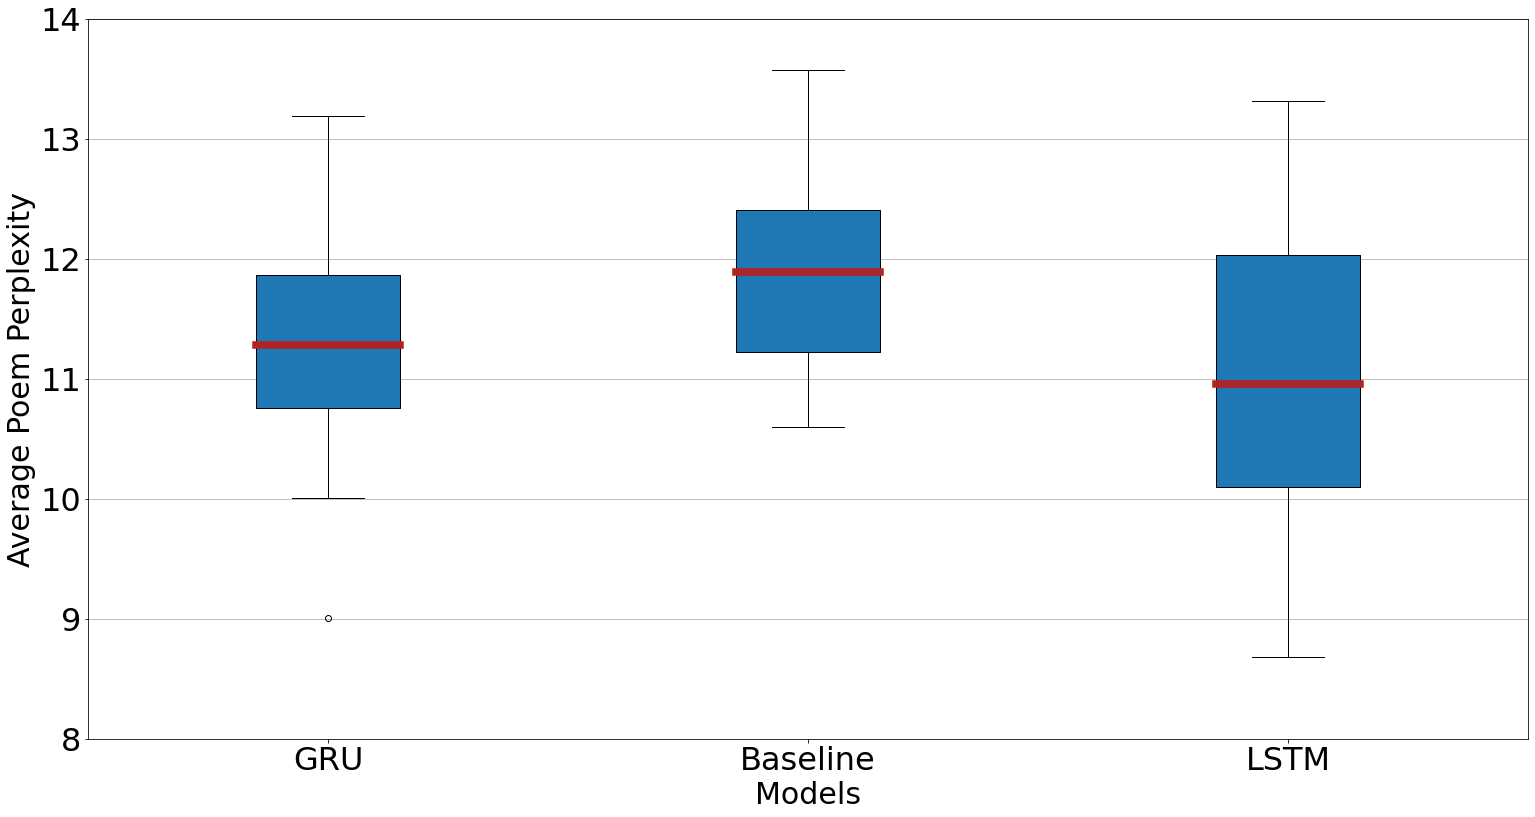

In [15]:
mpl.rcParams['font.size'] = 32
medianprops = dict(linestyle='-', linewidth=7.5, color='firebrick')
#threshold = 1
fig = plt.figure(figsize =(20, 10))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data, patch_artist=True, medianprops=medianprops, labels=labels) 
#ax.axvline(threshold, c = "red", linestyle="--", alpha = 0.5)
ax.set_ylim(8,14)
plt.ylabel('Average Poem Perplexity', fontsize=30)
plt.xlabel('Models', fontsize=30)
plt.gca().yaxis.grid(True)
plt.savefig("boxplot.jpg", bbox_inches='tight')
plt.show()

In [16]:
import pandas as pd 

d = {
    
    'GRU': perplexity_1, 
    'Baseline': perplexity_2, 
    'LSTM': perplexity_3,
}

df = pd.DataFrame(data=d)
df.head()

,GRU,Baseline,LSTM
0,11.184586,12.013133,10.101474
1,10.553114,11.740659,12.995937
2,9.009901,11.828121,10.922941
3,11.548757,11.240891,11.416070
4,11.300845,11.217138,10.412036


In [17]:
model_names = df.columns #names of models

mean = df[model_names].mean()
pp_25per = df[model_names].quantile(q=.25)
pp_75per = df[model_names].quantile(q=.75)
maxPP = df[model_names].max()
minPP = df[model_names].min()
pp_5per = df[model_names].quantile(q=.05)
pp_95per = df[model_names].quantile(q=.95)

In [18]:
data_frames = [mean, pp_25per, pp_75per, maxPP, minPP, pp_5per, pp_95per]
column_names = ['meanPP', 'PP_25per', 'PP_75per', 'maxPP', 'minPP', 'PP_5per', 'PP_95per']
merged_df = pd.concat(data_frames, join='outer', axis=1)
merged_df.columns =column_names

In [19]:
merged_df

,meanPP,PP_25per,PP_75per,maxPP,minPP,PP_5per,PP_95per
GRU,11.321432,10.758892,11.865084,13.187652,9.009901,10.090476,12.853442
Baseline,11.926916,11.223076,12.410298,14.338148,10.597450,10.836687,13.368404
LSTM,11.075482,10.098491,12.028644,13.318269,8.679365,9.231934,12.955720


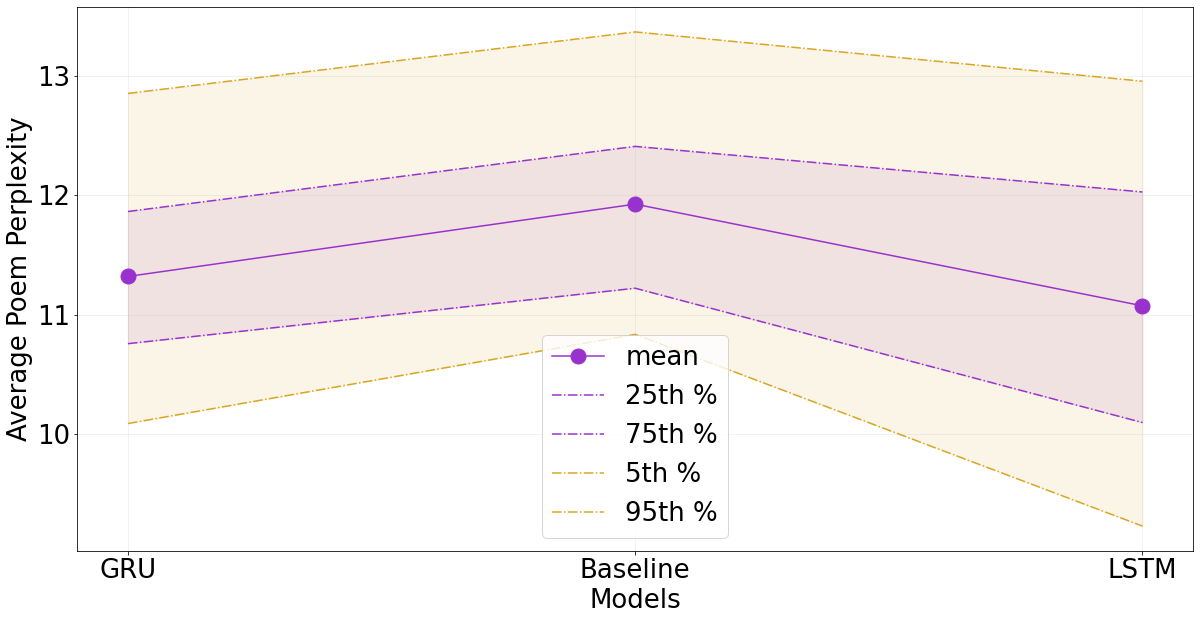

In [20]:
# source: https://towardsdatascience.com/the-matplotlib-line-plot-that-crushes-the-box-plot-912f8d2acd49


# Set the font size for all text on the plot
mpl.rcParams['font.size'] = 26

x = merged_df.index
y = merged_df.meanPP
y_low = merged_df.PP_25per
y_high = merged_df.PP_75per
y1_low = merged_df.PP_5per
y1_high = merged_df.PP_95per

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(x, y, color='darkorchid', marker='o', label='mean', markersize=15)
ax.plot(x, y_low, color='darkorchid', linestyle='-.', label='25th %')
ax.plot(x, y_high, color='darkorchid', linestyle='-.', label='75th %')
ax.plot(x, y1_low, color='goldenrod', linestyle='-.', label='5th %')
ax.plot(x, y1_high, color='goldenrod', linestyle='-.', label='95th %')
ax.legend()

ax.fill_between(x, y_low, y_high, alpha = .1, color = 'darkorchid')
ax.fill_between(x, y1_low, y1_high, alpha = .1, color = 'goldenrod')

ax.grid(alpha = .2, which='both') 
ax.set_ylabel('Average Poem Perplexity', fontsize=26)
ax.set_xlabel('Models', fontsize=26)

plt.savefig("visual_graph.jpg", bbox_inches='tight')
plt.show()
